### Metrics and Signatures for Meuse model with wflow_sbm and regional MTS-LSTM

Models: 
- MTS-LSTM Era5 forcing, HydroMT statics, trained on all 5 Meuse catchments
- MTS-LSTM Era5 forcing, HydroMT statics, trained on 4 Meuse catchments, tested in 5th

Results
- Load wflow daily and hourly results for Meuse catchments
- Load MTS-LSTM model results for Meuse catchments
- Load observed streamflow
- Load forcing precipitation timeseries

Plot: 
- timeseries plots for all Meuse catchments

Metrics:
- Load/Calculate peak metrics
- Load metrics and combine with peak metrics

Signatures:
- Load/Calcualte signatures

Comparison:
- Table with mean metrics and sigantures per model, per catchment
- Corellation between signatures based on observed streamflow and modeled streamflow

Flow duratino curves
- normal
- log 

### Imports etc

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from pandas.plotting import autocorrelation_plot, scatter_matrix

import os
import pickle
from collections import defaultdict
from typing import List, Dict, Tuple
from tqdm.notebook import tqdm
from pathlib import Path

from scipy.stats import pearsonr

from neuralhydrology.evaluation.signatures import calculate_signatures, get_available_signatures
from neuralhydrology.evaluation.metrics import calculate_metrics

from peak_magnitude import mean_peak_magnitude

In [30]:
models = ['lstm', 'wflow', 'obs']
meuse_dir = 'data/Meuse/'
lstm_dir = 'data/results/Meuse_regional_MTS-LSTM/'

### Data loading
#### load wflow results daily

In [5]:
frequencies = ['1D', '1H']

# observations only reach from 2005 until 2018
# start_date = pd.to_datetime('1981-01-01', format='%Y-%m-%d')   # for simulations
start_date = pd.to_datetime('2005-10-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2017-09-30', format='%Y-%m-%d')

catchment_ids_wflow = ['Q_6', 'Q_13', 'Q_701', 'Q_702', 'Q_703']
catchment_ids_obs = [6, 13, 701, 702, 703]

areas = [551.65, 305.82, 162.81, 232.15, 123.91]

In [6]:
# wflow predictions in m3/s
wflow_meuse_sim_d = pd.read_csv('data/Meuse/wflow_output_daily.csv', index_col='time')
wflow_meuse_sim_d = wflow_meuse_sim_d[catchment_ids_wflow] 
# wflow_meuse_sim_d.head()

In [7]:
# df to xarray ds
datasets = []
for catchm in wflow_meuse_sim_d.columns:
    df = wflow_meuse_sim_d.filter([catchm], axis=1)
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.rename({catchm: 'Qsim_m3s'})
    ds['catchments'] = int(catchm.split('_')[-1])
    datasets.append(ds)
    
wflow_sim_d = xr.concat(datasets, dim="catchments")
wflow_sim_d['time'] = pd.to_datetime(wflow_sim_d.time.values)
wflow_sim_d = wflow_sim_d.sel(time=slice(start_date, end_date))

# wflow_sim_d

#### load wflow results hourly

In [10]:
# wflow predictions in m3/s
wflow_meuse_sim_h = pd.read_csv('data/Meuse/wflow_output_hourly.csv', index_col='time')
wflow_meuse_sim_h = wflow_meuse_sim_h[catchment_ids_wflow]
# wflow_meuse_sim_h.head()

In [11]:
# df to xarray ds
datasets = []
for catchm in wflow_meuse_sim_h.columns:
    df = wflow_meuse_sim_h.filter([catchm], axis=1)
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.rename({catchm: 'Qsim_m3s'})
    ds['catchments'] = int(catchm.split('_')[-1])
    datasets.append(ds)
    
wflow_sim_h = xr.concat(datasets, dim="catchments")
wflow_sim_h['time'] = pd.to_datetime(wflow_sim_h.time.values)
wflow_sim_h = wflow_sim_h.sel(time=slice(start_date, end_date))

# wflow_sim_h

#### load Meuse observations

In [12]:
# Meuse observations in m3/s - HOURLY - BELGIAN CATCHMENTS
meuse_obs_h = xr.open_dataset('data/Meuse/qobs_hourly_belgian_catch.nc')
meuse_obs_h  = meuse_obs_h.sel({'catchments': catchment_ids_obs})
meuse_obs_h = meuse_obs_h.sel(time=slice(start_date, end_date))

# Meuse observations in m3/s - DAILY - BELGIAN CATCHMENTS
meuse_obs_d = meuse_obs_h.resample(time='1D').mean()
# meuse_obs_d
# meuse_obs_h

#### load Meuse regional MTS-LSTM results (daily and hourly)

In [13]:
# Q in mm/h
with open('data/results/Meuse_regional_MTS-LSTM/test_results.p', 'rb') as f:
    lstm_results = pickle.load(f)
lstm_results['meuse_6']['1D'].keys()

dict_keys(['xr', 'NSE_1D', 'KGE_1D', 'RMSE_1D', 'FHV_1D', 'Peak-Timing_1D'])

### Load forcing precipitation time-series for Meuse catchments
required to caluclate runoff ratio and baseflow signature

In [27]:
data_dir = 'data/time-series/Meuse/'
datasets = []
for catchment in catchment_ids_obs:
    ds = xr.open_dataset(data_dir + 'meuse_' + str(catchment) + '.nc')
    datasets.append(ds)
forcing_ds_era5 = xr.concat(datasets, dim='basin')
forcing_ds_era5 = forcing_ds_era5.drop_vars('spatial_ref')

precip_era5 = forcing_ds_era5.precip
precip_era5 = precip_era5.rename({'date': 'datetime'})
# precip_era5

### Plots
#### plotting wflow sim, lstm sim and meuse obs together

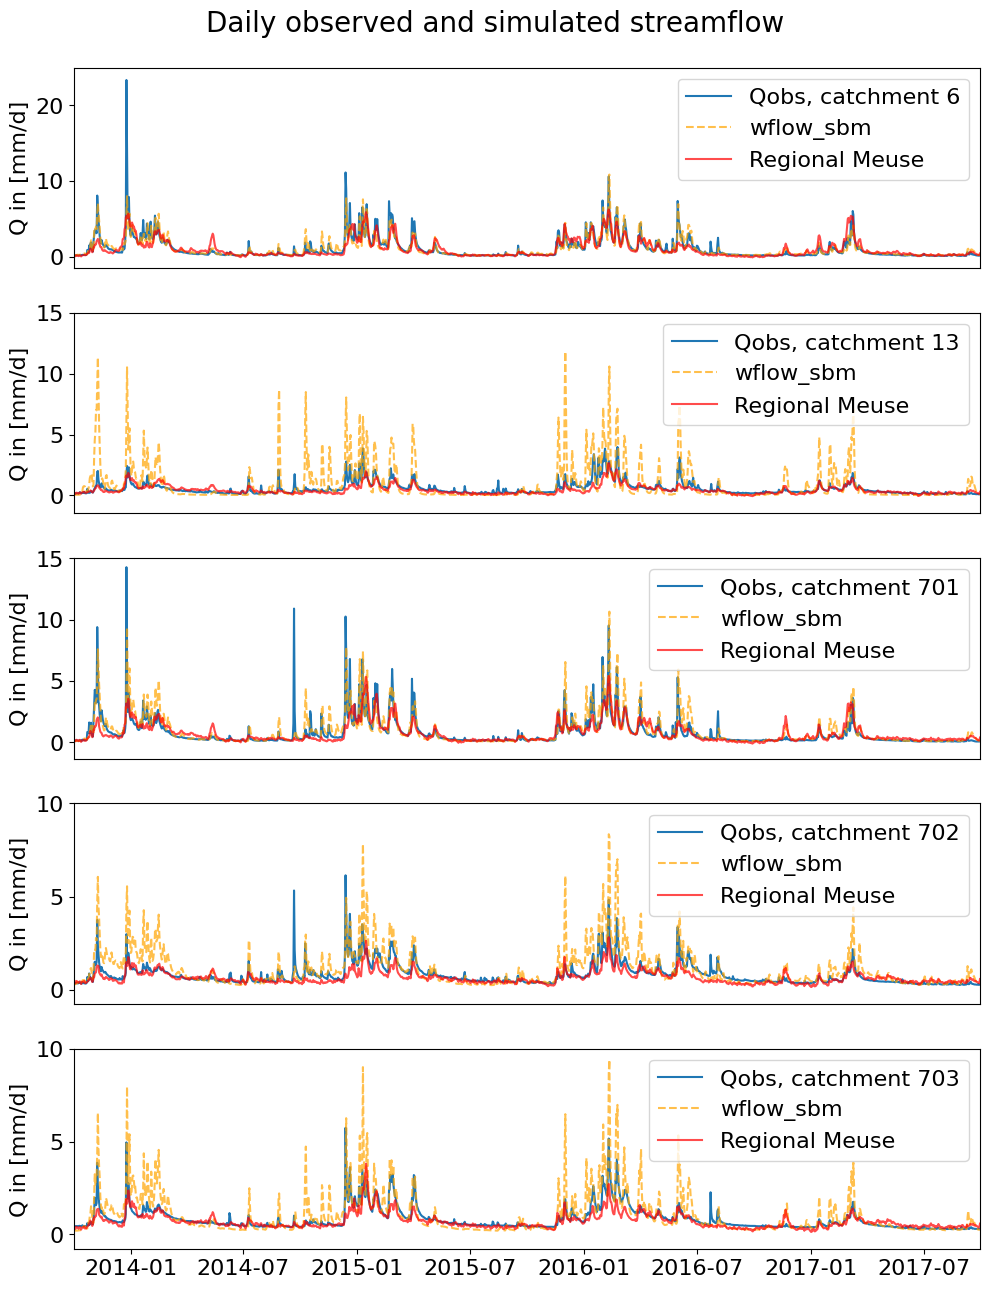

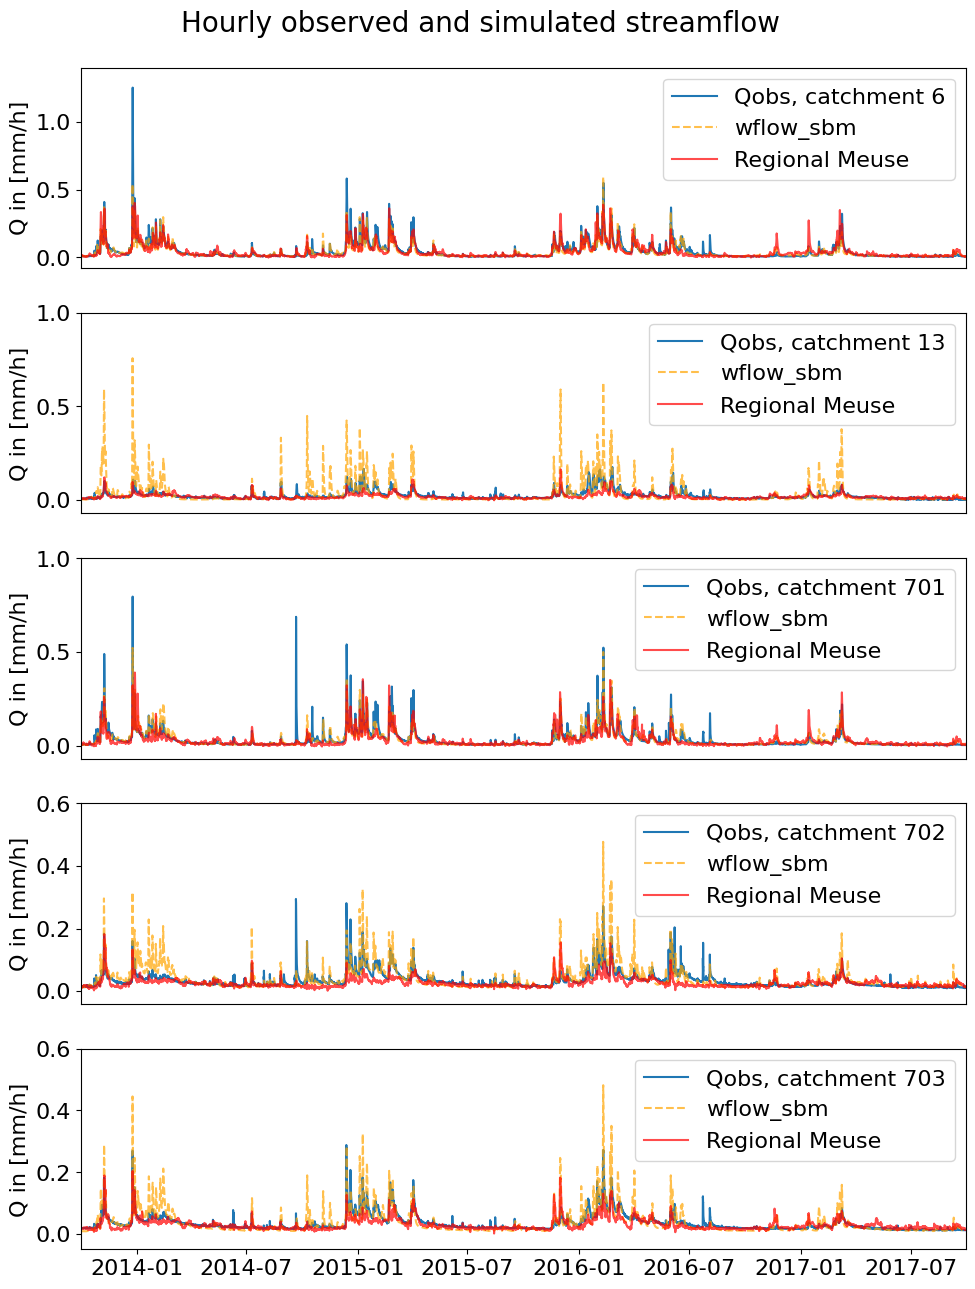

In [15]:
## Q in m3/s / m2 / 10**6 m2/mm2 * 1000 mm/m * 3600 s/h = mm/h * 24 h/d = mm/d

ylims = [25, 15, 15, 10, 10]
ylims_h = [1.4, 1, 1, 0.6, 0.6]

for freq in frequencies:
        
    fig, axes = plt.subplots(figsize=(10, 15), sharex=True)
    
    if freq == '1D':
        meuse_obs = meuse_obs_d
        wflow_sim = wflow_sim_d
        title = 'Daily observed and simulated streamflow'
    elif freq == '1H':
        meuse_obs = meuse_obs_h
        wflow_sim = wflow_sim_h
        title = 'Hourly observed and simulated streamflow'
        
    for i, catchm in enumerate(meuse_obs.catchments.values):        
        ax = plt.subplot(6, 1, i+1)
        # meuse obs
        qobs = meuse_obs.sel({'catchments':catchm}).\
                Qobs_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
        x = meuse_obs.time.values
        ax.plot(x, qobs, label=f'Qobs, catchment {catchm}')
        
        # wflow sim
        qsim_w = wflow_sim.sel({'catchments':catchm}).\
                Qsim_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
        x = wflow_sim.time.values
        ax.plot(x, qsim_w, label=f'wflow_sbm', alpha=0.7, color='orange', ls='--')
        
        # lstm sim
        catchment = 'meuse_' + str(catchm)
        ds = lstm_results[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
        qsim_l = ds['qobs_sim'] * (24 if freq == '1D' else 1)
        x = qsim_l.datetime.values
        ax.plot(x, qsim_l, label=f'Regional Meuse', color='red', alpha=0.7)
        
        plt.legend(fontsize=16)
        ax.set_title('')
        ax.set_ylabel('Q in [mm/d]' if freq=='1D' else 'Q in [mm/h]', fontsize=16)
        ax.set_xlim(left=pd.to_datetime('2013-10-01', format='%Y-%m-%d'), right=pd.to_datetime('2017-09-30', format='%Y-%m-%d'))
        ax.set_ylim(top=ylims[i] if freq == '1D' else ylims_h[i])
        
        if i < 4:
            ax.tick_params(labelcolor='none', axis='x', which='both', top=False, bottom=False, left=False, right=False)
            ax.get_xaxis().set_visible(False)
        ax.tick_params('both', labelsize=16)
            
            
    plt.suptitle(title, size=20, y=1)
    plt.tight_layout()
    plt.savefig(f'plots/time-series/meuse_{freq}')
    plt.show()
    

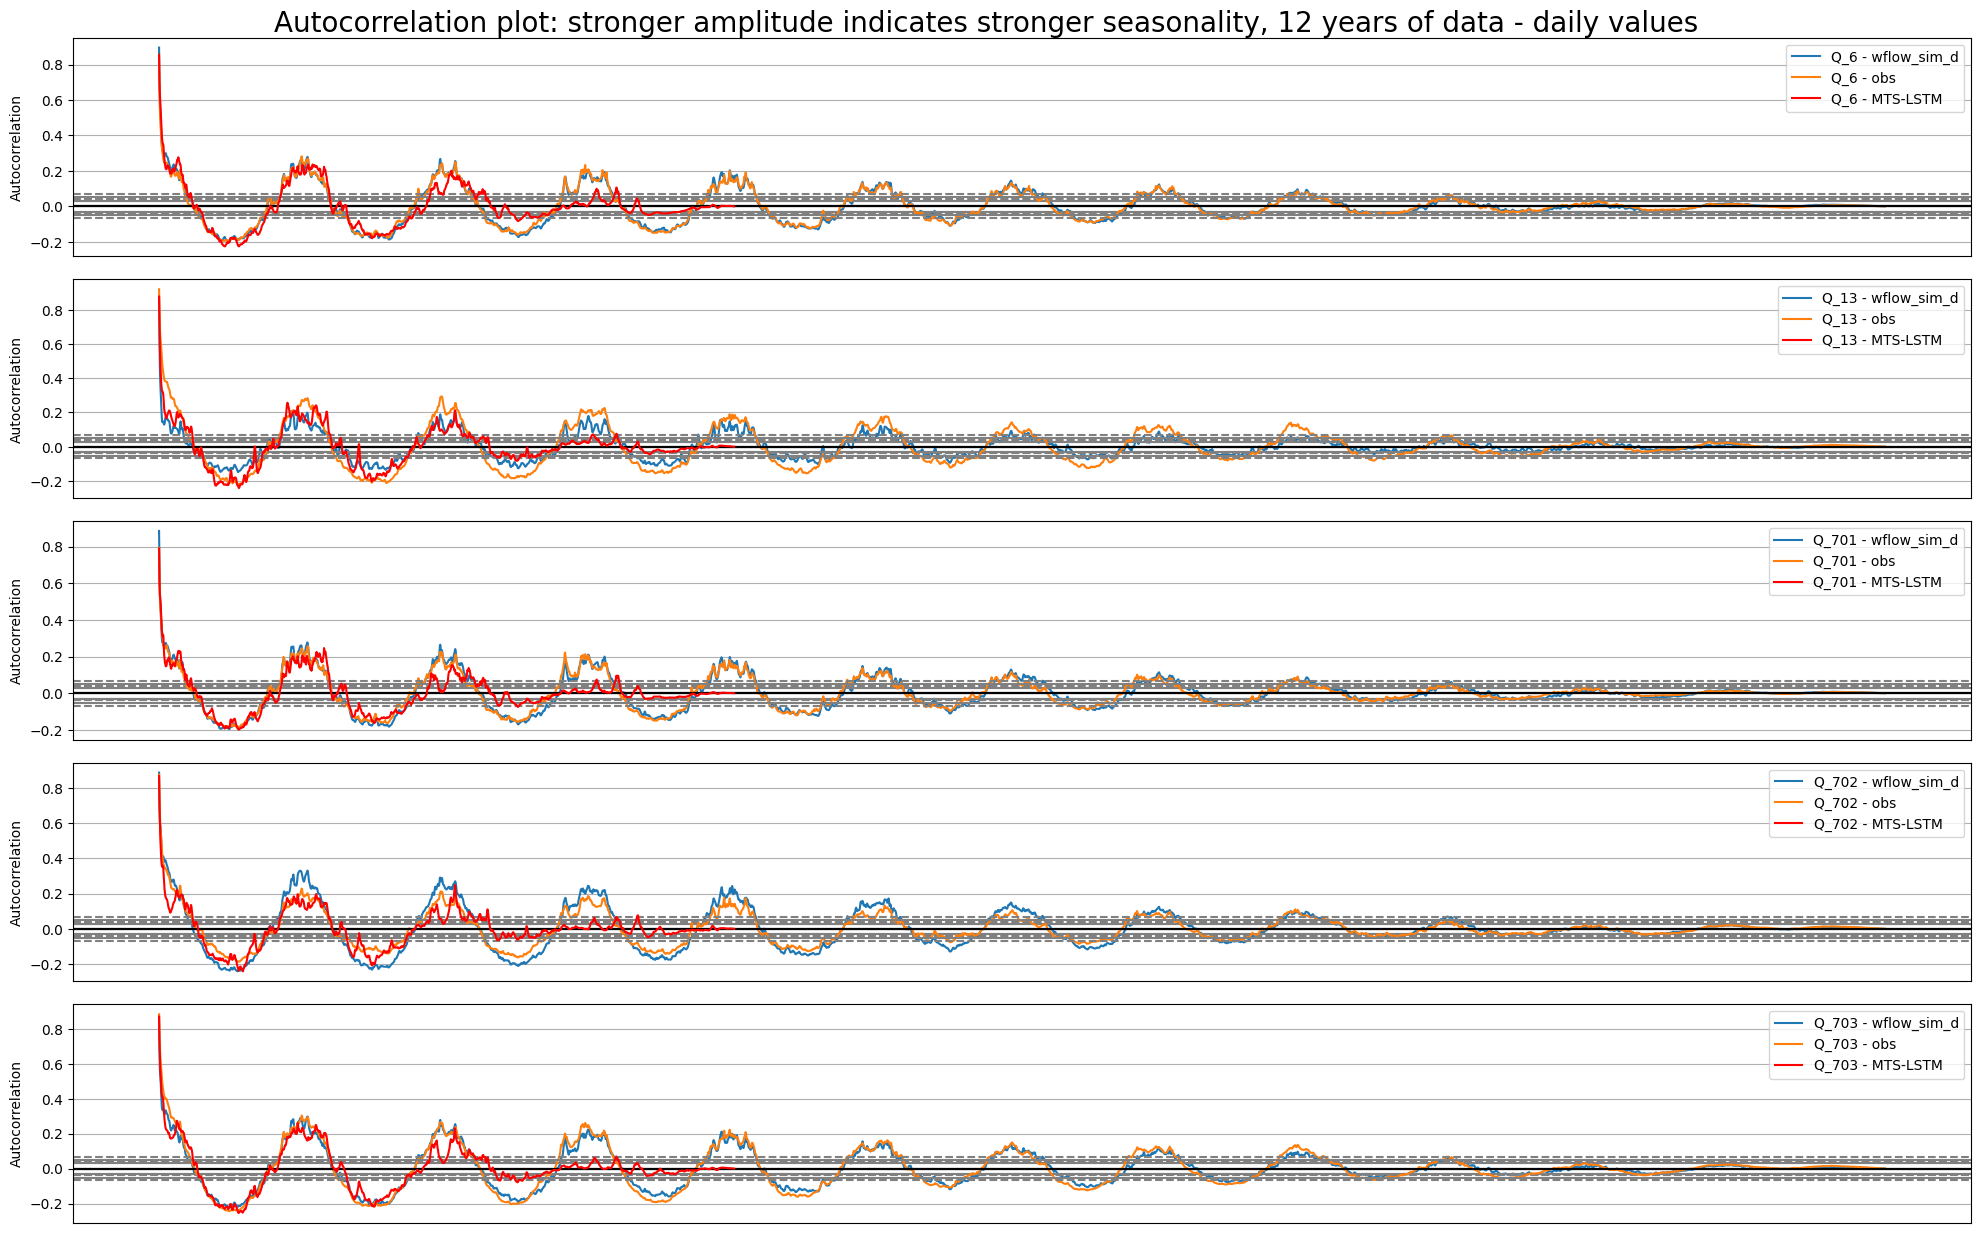

In [22]:
# autocorrelation plot --> shows seasonality

fig, axes = plt.subplots(figsize=(20, 15))
for i, catchm in enumerate(meuse_obs_d.catchments.values):

    ax = plt.subplot(6, 1, i+1)
    df = wflow_sim_d.sel({'catchments':catchm}).Qsim_m3s.to_dataframe()
    df = df.drop(columns='catchments')
    autocorrelation_plot(df, ax=ax, label=f'Q_{catchm} - wflow_sim_d') 
    
    df = meuse_obs_d.sel({'catchments':catchm}).Qobs_m3s.to_dataframe()
    df = df.drop(columns='catchments')
    autocorrelation_plot(df, ax=ax, label=f'Q_{catchm} - obs')
    plt.legend()
    
    catchment = 'meuse_' + str(catchm)
    ds = lstm_results[catchment][freq]['xr']
    ds = ds.isel(time_step = -1)
    ds = ds.drop('time_step')
    qsim_l = ds['qobs_sim'] * (24)
    df = qsim_l.to_dataframe()
    autocorrelation_plot(df, ax=ax, label=f'Q_{catchm} - MTS-LSTM', color='red')
    plt.legend()
    
    
    if i < 5:
        ax.tick_params(labelcolor='none', axis='x', which='both', top=False, bottom=False, left=False, right=False)
        ax.get_xaxis().set_visible(False)
plt.suptitle('Autocorrelation plot: stronger amplitude indicates stronger seasonality, 12 years of data - daily values', size=20)
plt.tight_layout()
plt.show()

### Load or calculate metrics
- nested dictionarry: DICT[model][catchment_ID][freq]
    - model: wflow, lstm, M4SE (str)
    - catchment_ID: 6, 13, 701, 702, 703 (int)
    - freq: 1D, 1H (str)
    - gives dataframe with metrics as columns: NSE, KGE, Pearson-r, FHV, Peak-Timing, abs_error, rel_error, peaks, sim<obs, sim>obs  


- set repeat to true if you want to recalculate the metrics, otherwise metrics are loaded from pickle file

In [23]:
metrics = ['NSE', 'KGE',  'FHV', 'Peak-Timing']

repeat = False
if not os.path.isfile(meuse_dir + '/metrics_regional.p') or repeat == True:
    metrics_dict = defaultdict(lambda: defaultdict(dict))

    for freq in frequencies:

        if freq == '1D':
            meuse_obs = meuse_obs_d
            wflow_sim = wflow_sim_d
        elif freq == '1H':
            meuse_obs = meuse_obs_h
            wflow_sim = wflow_sim_h

        for i, catchm in enumerate(catchment_ids_obs):
            # get simulated streamflow lstm
            catchment = 'meuse_' + str(catchm)
            ds = lstm_results[catchment][freq]['xr']
            if freq == '1H':
                ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            elif freq == '1D':
                ds = ds.isel(time_step = -1)
                ds = ds.drop('time_step')
                ds = ds.rename({'date': 'datetime'})
            qsim_l = ds['qobs_sim'] * (24 if freq == '1D' else 1)
            qobs_l = ds['qobs_obs'] * (24 if freq == '1D' else 1)
            
            # get simulated streamflow
            qsim = wflow_sim.sel({'catchments':catchm})['Qsim_m3s']
            qsim = qsim.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
            qsim = qsim.rename({'time': 'datetime'})

            # get observed streamflow
            qobs = meuse_obs.sel({'catchments':catchm})['Qobs_m3s']
            qobs = qobs.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
            qobs = qobs.rename({'time': 'datetime'})

            # convert to mm/h   ---   m3/s * 10**3 mmm/m * 3600 s/h / (10**6 * area)
            area = areas[i]
            qsim = qsim * 10**3 * 3600 / (area * 10**6)
            qobs = qobs * 10**3 * 3600 / (area * 10**6)

            # calculate metrics    
            metrics_w = calculate_metrics(qobs, qsim, metrics=metrics, resolution=freq)
            df_w = pd.DataFrame(data=metrics_w, 
                                    columns=list(metrics_w.keys()),
                                    index=[catchm])
            metrics_l = calculate_metrics(qobs_l, qsim_l, metrics=metrics, resolution=freq)
            df_l = pd.DataFrame(data=metrics_l, 
                                    columns=list(metrics_l.keys()),
                                    index=[catchm])

            # calculate peak metrics
            peak_wflow = mean_peak_magnitude(qobs, qsim, resolution=freq)
            df_peak_w = pd.DataFrame(data=peak_wflow, 
                                    columns=['abs_error', 'rel_error', 'peaks', 'sim<obs', 'sim>obs'],
                                    index=[catchm])
            peak_lstm = mean_peak_magnitude(qobs_l, qsim_l, resolution=freq)
            df_peak_l = pd.DataFrame(data=peak_lstm, 
                                    columns=['abs_error', 'rel_error', 'peaks', 'sim<obs', 'sim>obs'],
                                    index=[catchm])
            df_w = df_w.join(other=df_peak_w)
            df_l = df_l.join(other=df_peak_l)
            
            metrics_dict['wflow'][catchm][freq] = df_w 
            metrics_dict['lstm'][catchm][freq] = df_l
            
    # save to local drive
    pickle.dump({k: dict(v) for k, v in metrics_dict.items()}, Path(meuse_dir + '/metrics_regional.p').open('wb'))
    print('Calculated metrics and stored in pickle file on drive.')
    metrics_dict
else:
    # load from local drive
    metrics_dict = pickle.load(Path(meuse_dir + '/metrics_regional.p').open('rb'))
    print('Loaded metrics pickle file from drive')

# metrics_dict

Loaded metrics pickle file from drive


In [24]:
metrics_dict['wflow'][6]['1D']

,NSE,MSE,RMSE,KGE,Alpha-NSE,Pearson-r,Beta-NSE,FHV,FMS,FLV,Peak-Timing,abs_error,rel_error,peaks,sim<obs,sim>obs
6,0.745989,0.000994,0.031532,0.800402,0.854514,0.863792,0.007847,-16.072308,-18.084971,31.357605,1.0,0.1421,0.292828,7,6,1


### Calculate Signatures
- nested dictionarry: DICT[model][catchment_ID][freq][signature]
    - model: obs, lstm_no_stats, lstm_less_stats   (str)
    - catchment_ID: 6, 13, 701, 702, 703 (int)
    - freq: 1D, 1H (str)
    - signature: 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq', 'q95', 'q5', 'q_mean', 'hfd_mean', 'slope_fdc', 'stream_elas', 'runoff_ratio'


- set repeat to true if you want to recalculate the signatures, otherwise signatures are loaded from pickle file


In [25]:
all_signatures = get_available_signatures()
all_signatures.remove('baseflow_index')

all_signatures

['high_q_freq',
 'high_q_dur',
 'low_q_freq',
 'low_q_dur',
 'zero_q_freq',
 'q95',
 'q5',
 'q_mean',
 'hfd_mean',
 'slope_fdc',
 'stream_elas',
 'runoff_ratio']

In [29]:
repeat=False
if not os.path.isfile(meuse_dir + '/signatures_regional.p') or repeat==True:
    sign_dict = defaultdict(lambda: defaultdict(dict))
    for freq in frequencies:

        for i, catchm in enumerate(catchment_ids_obs):          
            if freq == '1D':
                meuse_obs = meuse_obs_d
                wflow_sim = wflow_sim_d
                c = 'meuse_' + str(catchm)
                f_precip = xr.DataArray(precip_era5.sel(basin=c).to_series().resample('1D').sum())
                      
            elif freq == '1H':
                meuse_obs = meuse_obs_h
                wflow_sim = wflow_sim_h
                c = 'meuse_' + str(catchm)
                f_precip = precip_era5.sel(basin=c)
                      
            
            # get simulated streamflow lstm
            ds = lstm_results[c][freq]['xr']
            if freq == '1H':
                ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            elif freq == '1D':
                ds = ds.isel(time_step = -1)
                ds = ds.drop('time_step')
                ds = ds.rename({'date': 'datetime'})
            qsim_l = ds['qobs_sim'] * (24 if freq == '1D' else 1)
            qobs_l = ds['qobs_obs'] * (24 if freq == '1D' else 1)
            
            # add stuff for hourly lstm results
                    
            # get simulated streamflow wflow
            qsim = wflow_sim.sel({'catchments':catchm})['Qsim_m3s']
            qsim = qsim.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
            qsim = qsim.rename({'time': 'datetime'})

            # get observed streamflow
            qobs = meuse_obs.sel({'catchments':catchm})['Qobs_m3s']
            qobs = qobs.sel(time=slice(pd.to_datetime('2013-10-01', format='%Y-%m-%d'), None))
            qobs = qobs.rename({'time': 'datetime'})

            # convert to mm/h   ---   m3/s * 10**3 mmm/m * 3600 s/h / (10**6 * area)
            area = areas[i]
            qsim = qsim * 10**3 * 3600 / (area * 10**6) * (24 if freq == '1D' else 1)
            qobs = qobs * 10**3 * 3600 / (area * 10**6) * (24 if freq == '1D' else 1)

            # clip predictions to 0
            qsim = xr.where(qsim < 0, 0, qsim)
            qsim_l = xr.where(qsim_l < 0, 0, qsim_l)

            # calculate signatures --> add loop through freq
            sign_dict['obs'][catchm][freq] = calculate_signatures(qobs, all_signatures + ['baseflow_index'],
                                                                    datetime_coord='datetime',
                                                                    prcp=f_precip)
            sign_dict['wflow'][catchm][freq] = calculate_signatures(qsim, all_signatures + ['baseflow_index'],
                                                                    datetime_coord='datetime',
                                                                    prcp=f_precip)
            sign_dict['lstm'][catchm][freq] = calculate_signatures(qsim_l, all_signatures + ['baseflow_index'],
                                                                    datetime_coord='datetime',
                                                                    prcp=f_precip)
                      
            # for baseflow index calculation, mask the array in the same places where obs has NaNs.
            masked_sim = qsim.copy()
            masked_sim[qobs.isnull()] = np.nan
            sign_dict['wflow'][catchm][freq]['baseflow_index'] = \
                calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']
            masked_sim = qsim_l.copy()
            masked_sim[qobs_l.isnull()] = np.nan
            sign_dict['lstm'][catchm][freq]['baseflow_index'] = \
                calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']
                      
    # save nested dict to local drive
    pickle.dump({k: dict(v) for k, v in sign_dict.items()}, Path(meuse_dir + '/signatures_regional.p').open('wb'))
    print('Calculated signatures and stored in pickle file on drive.')

else:
    # load from local drive
    sign_dict = pickle.load(Path(meuse_dir + '/signatures_regional.p').open('rb'))
    print('Loaded signatures pickle file from drive')   
    
# sign_dict

Loaded signatures pickle file from drive


### Show metrics & signatures in table and/or visualize

#### convert dictionarries with metrics and signatures to dataframes

In [31]:
def dict_to_df(model: str, results: dict, freqs: List[str]) -> pd.DataFrame:
    """Convert a nested dict into a MultiIndex DataFrame. """
    results = results[model].copy()
    for catchm in results.keys():
        for freq in freqs:
            keys = list(results[catchm][freq].keys())
            for key in keys:
                results[catchm][freq][key] = results[catchm][freq].pop(key)
    df = pd.DataFrame.from_dict({(model, catchm, freq): results[catchm][freq]
                                 for catchm in results.keys() 
                                 for freq in freqs},
                                orient='index')
    df = df.swaplevel(1, 2, axis=0)
    df.index.rename(['model', 'freq', 'catchment'], inplace=True)
    return df

def dict_to_df_metrics(model:str, results: dict, freqs: List[str]) -> pd.DataFrame:
    results = results[model].copy()
    for i, catchm in enumerate(results.keys()):
        for freq in freqs:
            df = results[catchm][freq]
            df = pd.concat({freq: df}, names=['freq'])
            df = pd.concat({model: df}, names=['model'])
            if i == 0:
                return_df = df
            else:
                return_df = return_df.append(df)
    return_df.index.rename(['model', 'freq', 'catchment'], inplace=True)
    return return_df

In [32]:
# create multiindex [model, freq, catchment] dataframe with metrics and one with signatures combined for all models

# metrics combined df
results_df_m_l = dict_to_df_metrics(models[0], metrics_dict, frequencies).sort_index()  
results_df_m_w = dict_to_df_metrics(models[1], metrics_dict, frequencies).sort_index()  
results_df_m = pd.concat((results_df_m_w, results_df_m_l), axis=0)

# signatures combined df
results_df_s = pd.concat([dict_to_df(model_name, sign_dict, frequencies)
                          for model_name in models]).sort_index()

# results_df_s
# results_df_m

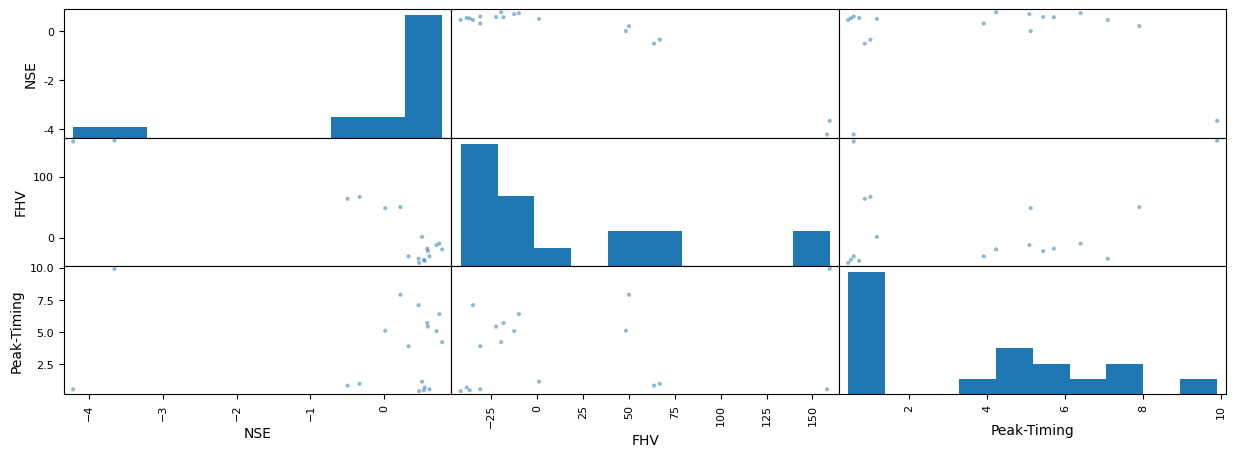

In [33]:
# results_df_m
scatter_matrix(results_df_m[['NSE', 'FHV', 'Peak-Timing']], figsize=(15, 5), diagonal='hist'); # diagonal='kde'

#### show table to compare metrics and signatures (median per model)

In [34]:
# metrics
drop_cols = ['Alpha-NSE', 'Beta-NSE', 'MSE', 'RMSE', 'Pearson-r', 'FMS', 'FLV']

medians_m = results_df_m.groupby(['model', 'freq']).median()
medians_m['NSE_mean'] = results_df_m['NSE'].groupby(['model', 'freq']).mean()
medians_m['NSE<0'] = results_df_m['NSE'].groupby(['model', 'freq']).apply(lambda x: (x<0).sum())
medians_m['KGE<-0.41'] = results_df_m[['KGE']].groupby(['model', 'freq']).apply(lambda x: (x<-0.41).sum())
medians_m.drop(columns=drop_cols, inplace=True)

display(medians_m.style.format('{:.3f}'))

In [35]:
# signatures
# determine correlation of signatures based on simulated streamflow and based on observed streamflow

signature_corr = pd.DataFrame(index=frequencies, columns=results_df_s.columns, dtype=float)
signature_corr.index.rename('freq', inplace=True)
signature_corr = pd.concat({models[1]: signature_corr}, names=['model'])
signature_corr.loc[(models[0], frequencies[0]),:] = np.full([1, len(signature_corr.columns)], np.nan).tolist()[0]
signature_corr.loc[(models[0], frequencies[1]),:] = np.full([1, len(signature_corr.columns)], np.nan).tolist()[0]

for freq in frequencies:    
    for model in models[:-1]:
        for sig in signature_corr.columns:
            sig_obs = results_df_s.loc(axis=0)[models[-1], freq][sig].sort_index()
            sig_sim = results_df_s.loc(axis=0)[model, freq][sig].reindex(sig_obs.index)
            mask = ~(pd.isna(sig_obs) | pd.isna(sig_sim))
            if mask.sum() ==0:
                continue
            signature_corr.loc(axis=0)[model, freq][sig]  = pearsonr(sig_obs[mask].values, sig_sim[mask].values)[0]

print(f'Correlation of signatures from simulated streamflow with those from observed streamflow') 
signature_corr

Correlation of signatures from simulated streamflow with those from observed streamflow


C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


high_q_freq  high_q_dur  low_q_freq  low_q_dur  zero_q_freq  \
model freq                                                                
wflow 1D      -0.172481    0.206252    0.033154  -0.777155          NaN   
      1H      -0.081403    0.191809   -0.174302  -0.994433          NaN   
lstm  1D       0.919777    1.000000    0.967689   0.959834          NaN   
      1H       0.974824    0.787822    0.976498   0.986850          NaN   

                 q95        q5    q_mean  hfd_mean  slope_fdc  stream_elas  \
model freq                                                                   
wflow 1D    0.138972  0.854855  0.705829  0.426986   0.386247     0.397190   
      1H   -0.024774  0.821033  0.705418  0.481074   0.507435     0.117256   
lstm  1D    0.994855  0.979294  0.983316  0.954380   0.966558    -0.880320   
      1H    0.997161  0.991123  0.982725  0.949354   0.995241    -0.508487   

            runoff_ratio  baseflow_index  
model freq                                
wflow 1D        0.599833        0.404645  
      1H        0.608123        0.374901  
lstm  1D        0.980708        0.995969  
      1H        0.981123        0.989210

#### compare metrics and signatures per catchment

In [36]:
# metrics

compare_m = results_df_m.swaplevel(i=-3, j=-1).sort_index()

compare_m.drop(columns=drop_cols, inplace=True)
compare_m.style.format('{:.2f}')

In [37]:
# signatures
# high_q > 9 * mean Q
# low_q < 0.2 * mean Q
keep_cols = ['high_q_freq', 'high_q_dur', 'q95', 'hfd_mean', 'runoff_ratio']


compare_s = results_df_s.swaplevel(i=-3, j=-1).sort_index()

# hfd mean from hours to days for hourly timescale
compare_s.loc[pd.IndexSlice[:, '1H'], 'hfd_mean'] = compare_s.loc[pd.IndexSlice[:, '1H'], 'hfd_mean'] / 24

compare_s[keep_cols].style.format('{:.2f}')

## Flow duration curves

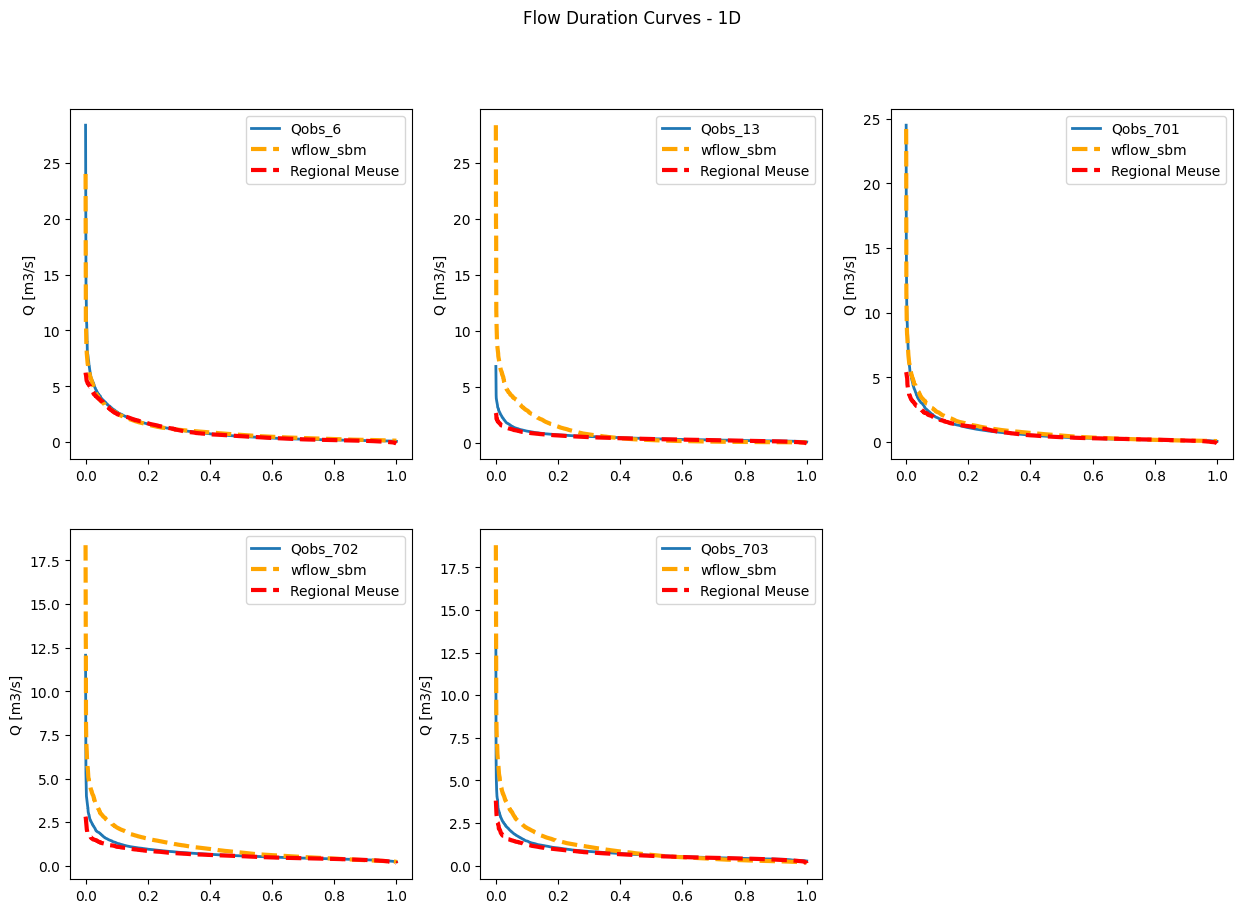

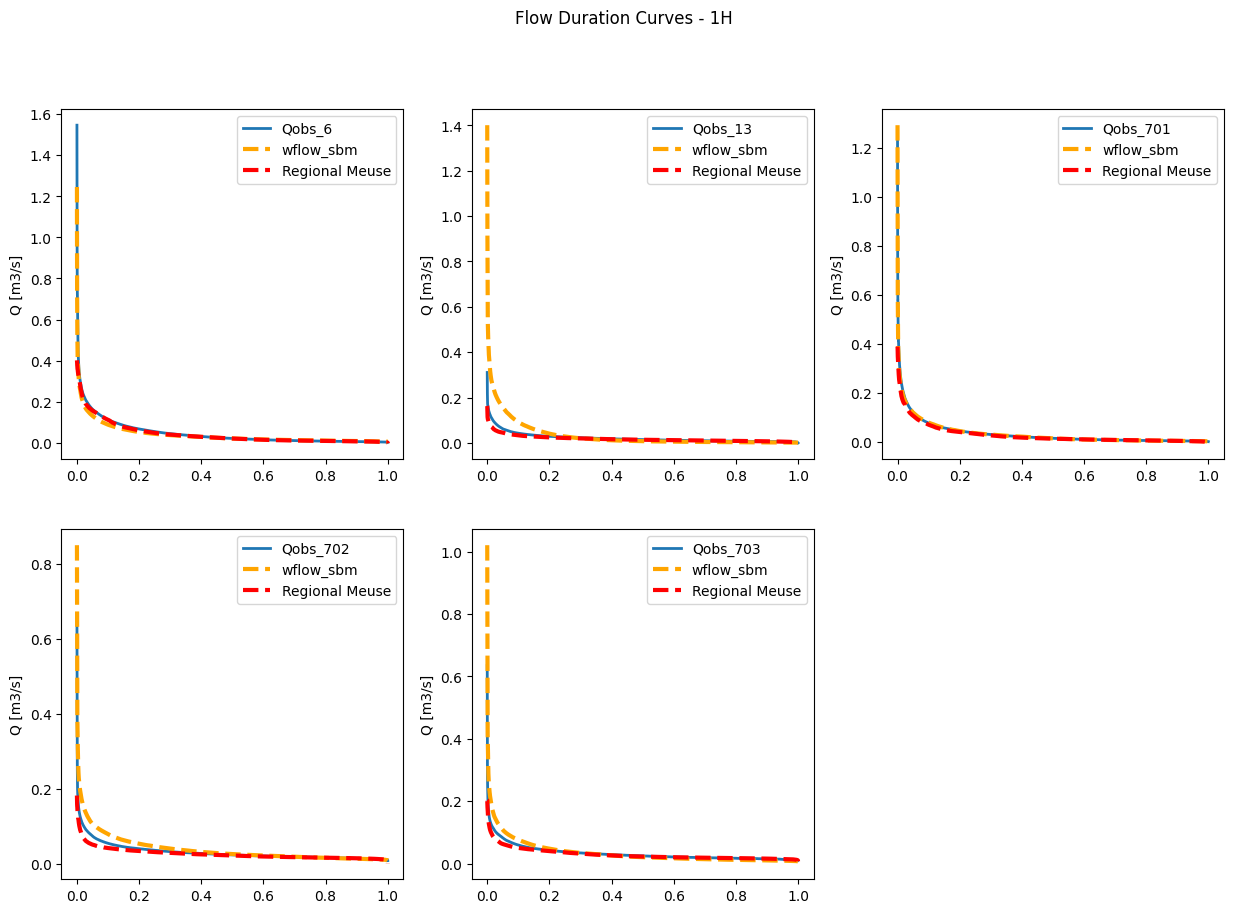

In [40]:
colors = [i for i in get_cmap('tab20b').colors]


for freq in frequencies:
    fig = plt.subplots(figsize=(15, 10))
    for i, catchm in enumerate(meuse_obs.catchments.values):

        if freq == '1D':
            meuse_obs = meuse_obs_d
            wflow_sim = wflow_sim_d
        elif freq == '1H':
            meuse_obs = meuse_obs_h
            wflow_sim = wflow_sim_h

        ax = plt.subplot(2, 3, i+1)
        # get simulated streamflow
        qsim = wflow_sim.sel(time=slice(start_date, end_date))
        qsim = qsim.sel({'catchments':catchm}).\
                Qsim_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
        
        # get observed streamflow
        qobs = meuse_obs.sel({'catchments':catchm}).\
                Qobs_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)

        

        # lstm sim
        catchment = 'meuse_' + str(catchm)
        ds = lstm_results[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
            ds = ds.sel(datetime=slice(start_date, end_date))
        qsim_l = ds['qobs_sim'] * (24 if freq == '1D' else 1)

        fdc = -np.sort(-qobs)
        x = np.linspace(0, 1, len(fdc))
        plt.plot(x, fdc, label=f'Qobs_{catchm}', color='C0', lw=2)

        fdc = -np.sort(-qsim) 
        x = np.linspace(0, 1, len(fdc))

        plt.plot(x, fdc, label=f'wflow_sbm', color='orange', lw=3, ls='--')  
  
        fdc = -np.sort(-qsim_l)        
        x = np.linspace(0, 1, len(fdc))
        plt.plot(x, fdc, label=f'Regional Meuse', color='red', ls='--', lw=3)
        
        plt.ylabel('Q [m3/s]')
        plt.legend()
    plt.suptitle(f'Flow Duration Curves - {freq}')

C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log
C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log


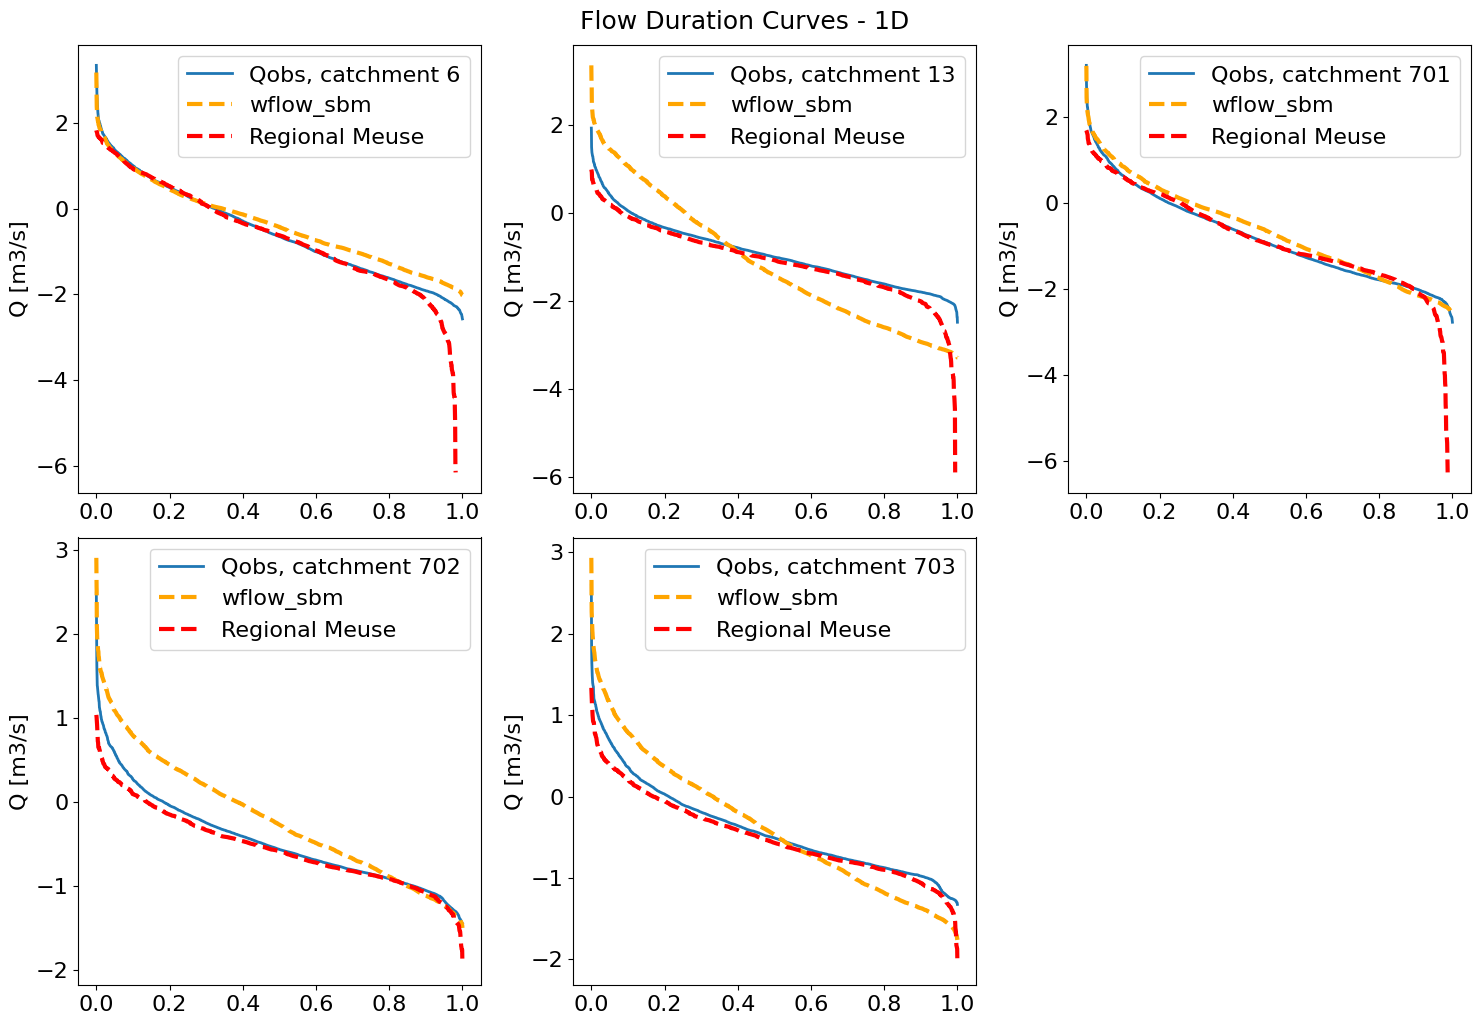

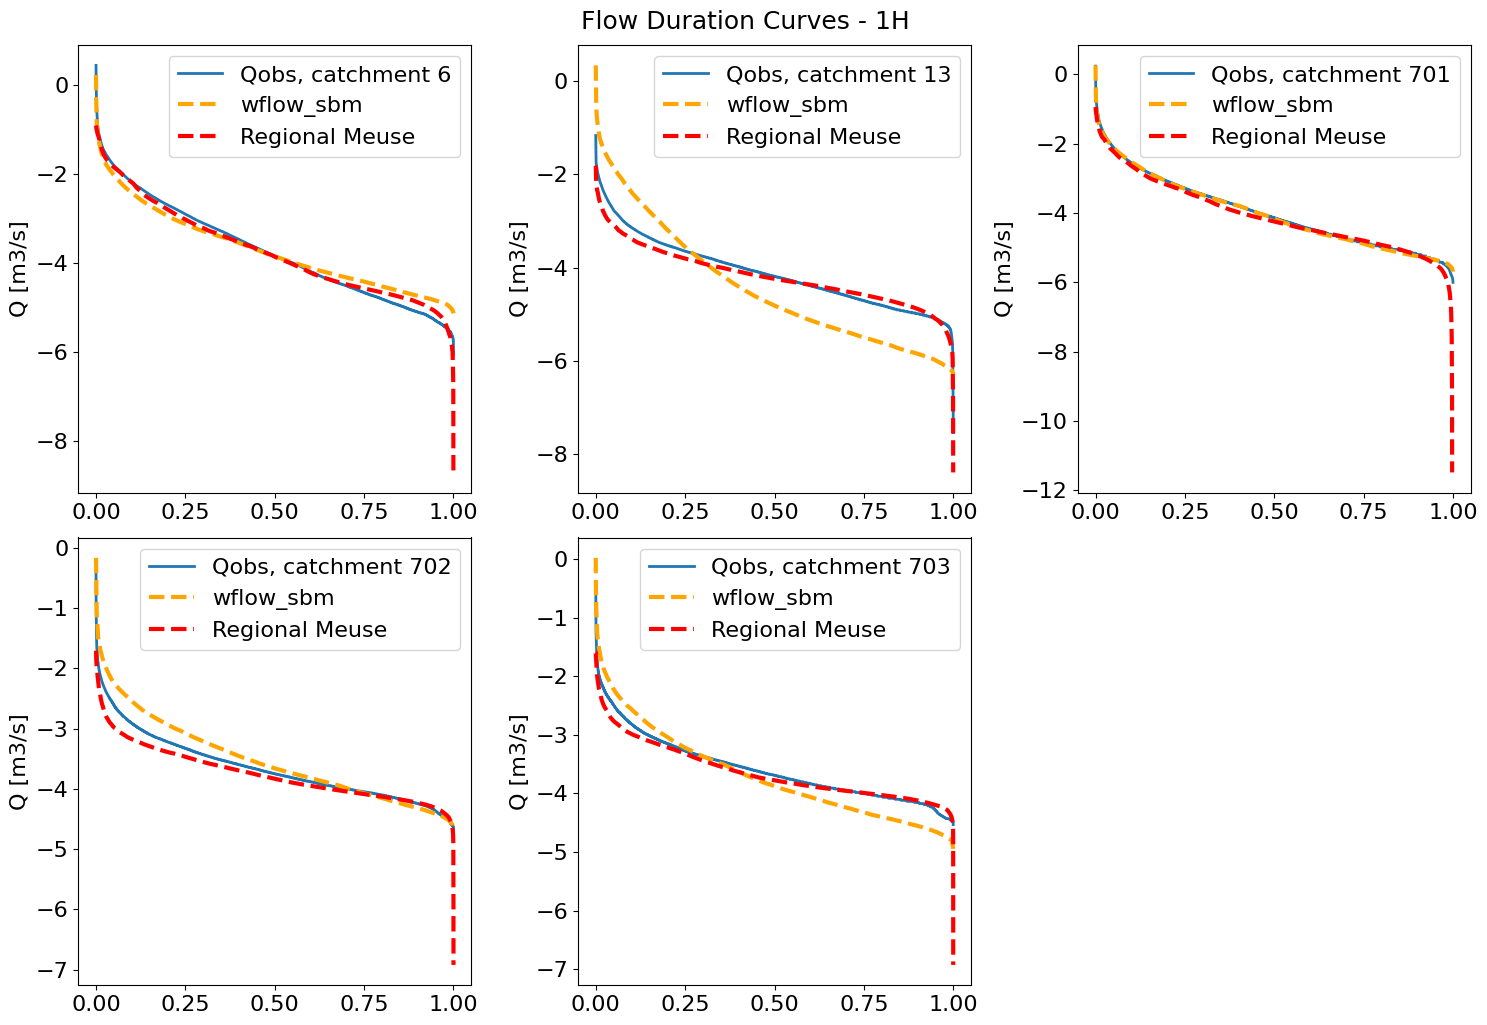

In [39]:
colors = [i for i in get_cmap('tab20b').colors]


for freq in frequencies:
    fig = plt.subplots(figsize=(15, 10))
    for i, catchm in enumerate(meuse_obs.catchments.values):

        if freq == '1D':
            meuse_obs = meuse_obs_d
            wflow_sim = wflow_sim_d
        elif freq == '1H':
            meuse_obs = meuse_obs_h
            wflow_sim = wflow_sim_h

        ax = plt.subplot(2, 3, i+1)
        # get simulated streamflow
        qsim = wflow_sim.sel(time=slice(start_date, end_date))
        qsim = qsim.sel({'catchments':catchm}).\
                Qsim_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)
        
        # get observed streamflow
        qobs = meuse_obs.sel({'catchments':catchm}).\
                Qobs_m3s.values / areas[i] * 1000 * 3600 / 1000000 * (24 if freq == '1D' else 1)

        

        # lstm sim
        catchment = 'meuse_' + str(catchm)
        ds = lstm_results[catchment][freq]['xr']
        if freq == '1H':
            ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
            ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
            ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
            ds = ds.sel(datetime=slice(start_date, end_date))
        elif freq == '1D':
            ds = ds.isel(time_step = -1)
            ds = ds.drop('time_step')
            ds = ds.rename({'date': 'datetime'})
            ds = ds.sel(datetime=slice(start_date, end_date))
        qsim_l = ds['qobs_sim'].values * (24 if freq == '1D' else 1)
        

        qobs_log = np.log(qobs)
        fdc = -np.sort(-qobs_log)
        x = np.linspace(0, 1, len(fdc))
        ax.plot(x, fdc, label=f'Qobs, catchment {catchm}', color='C0', lw=2)

        qsim_log = np.log(qsim)
        fdc = -np.sort(-qsim_log) 
        x = np.linspace(0, 1, len(fdc))
        ax.plot(x, fdc, label=f'wflow_sbm', color='orange', lw=3, ls='--')  

        qsim_l_log = np.log(qsim_l)
        fdc = -np.sort(-qsim_l_log)        
        x = np.linspace(0, 1, len(fdc))
        ax.plot(x, fdc, label=f'Regional Meuse', color='red', ls='--', lw=3)
        
        plt.ylabel('Q [m3/s]',  fontsize=16)
        ax.tick_params('both', labelsize=16)
        plt.legend( fontsize=16)
    plt.tight_layout()
    plt.suptitle(f'Flow Duration Curves - {freq}', y=1.02, fontsize=18)